# BUILDING AND TESTING A CPPI WITH DRAWDOWN CONSTRAINTS
* Download datasets: S&P500, Dax and Nikkei225
* Set the parameters of the CPPI-strategy
* Run the CPPI-strategy
* Chart the CPPI-strategy
* Generalizing the CPPI algorithm in a function
* Add a drawdown constraint to the generalized CPPI function
* Run the CPPI algo through a function
* Simulating CPPI with drawdown constraints through Monte Carlo simulation
* Smulating the CPPI through block bootstrapping

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# FUNCTIONS USED IN THIS NOTEBOOK

In [2]:
#FUNCTIONS FOR ABSOLUTE PERFORMANCE

def annualized_return(r,per):
    """ Annualized return calculated from a pd.Series or DataFrame.r may contain null values at start series.
    Args:
        r(pd.Series or Dataframe):return per period in R-format (eg:0.005=0.5%)
        per(int): the period adjustment (12 for monthly periods, 52 for weekly periods, 250 for daily periods)
    Returns:
        Float: annualized return
    """
    yearfraq=(r.shape[0]-r.isna().sum())/per
    wealth=(1+r).prod()
    annual_return=wealth**(1/yearfraq)-1
    return annual_return  

def annualized_vol(r,per):
    """ Annualized volatility calculated from a return series.
    Args:
        r(pd.Series):return series per period in R-format (e.g: 0.005 = 0.5%)
        per(int): the period adjustment (12 for monthly periods, 52 for weekly periods, 250 for daily periods)
    Returns:
        Float: annualized volatility
    """
    annual_vol=r.dropna().std()*np.sqrt(per)
    return annual_vol

def downside_vol(r,per):
    """ Annualized volatility of the negative returns calculated from a return series.
    Args:
        r(pd.Series):return series per period in R-format (e.g: 0.005 = 0.5%)
        per(int): the period adjustment (12 for monthly periods, 52 for weekly periods, 250 for daily periods)
    Returns:
        Float: annualized volatility
    """
    down_vol=r.dropna()[r<0].std()*np.sqrt(per)
    return down_vol

def max_drawdown(r):
    """ Calculates the maximum drawdown over total period of a return series
    Args:
        r(pd.Series or DataFrame):the return series
    Returns:
        Float: maximum drawdown
    """
    wealth_index=(1+r).cumprod()
    max_wealth=wealth_index.cummax()
    drawdown_index=wealth_index/max_wealth-1
    max_dd=drawdown_index.min()
    return max_dd

def drawdown_series(r):
    """ Calculates the rolling drawdown of a return series
    Args:
        r(pd.Series):the return series in R format (e.g.: 5% = 0.05)
    Returns:
        pd.Series: rolling drawdown
    """
    wealth_index=(1+r).cumprod()
    max_wealth=wealth_index.cummax()
    drawdown_index=wealth_index/max_wealth-1
    return drawdown_index

def sharpe_ratio(r1,r2,per):
    """ Sharpe ratio of a strategy versus risk-free rate based on return series input.
    Args:
        r1(pd.Series):return series of strategy per period in R-format (e.g: 0.005 = 0.5%)
        r2:return series of risk-free asset per period in R-format
        per(int): the period adjustment (12 for monthly periods, 52 for weekly periods, 250 for daily periods)
    Returns:
        Float: sharpe ratio
    """
    strategy_return=annualized_return(r1,per)
    risk_free_return=annualized_return(r2,per)
    strategy_volatility=annualized_vol(r1,per)
    sharpe=(strategy_return-risk_free_return)/strategy_volatility
    
    return sharpe

def sortino_ratio(r1,r2,per):
    """ Sortino ratio of a strategy versus risk-free rate based on return series input.
    Args:
        r1(pd.Series):return series of strategy per period in R-format (e.g: 0.005 = 0.5%)
        r2:return series of risk-free asset per period in R-format
        per(int): the period adjustment (12 for monthly periods, 52 for weekly periods, 250 for daily periods)
    Returns:
        Float: sharpe ratio
    """
    strategy_return=annualized_return(r1,per)
    risk_free_return=annualized_return(r2,per)
    strategy_downside_volatility=downside_vol(r1,per)
    sortino=(strategy_return-risk_free_return)/strategy_downside_volatility
    
    return sortino


def mar_ratio(r,per=12):
    """ MAR ratio of a strategy: annulized return divided by maximum drawdown for a return series
    Args:
        r(pd.Series):return series of strategy per period in R-format (e.g: 0.005 = 0.5%)
        per: period adjustement for frequency period of series.default is 12 for monthly frequency (52 for weeks, 250 for days).
            
    Returns:
        Float: MAR-ratio
    """
    r_annualized_return=annualized_return(r,per)
    r_max_drawdown=max_drawdown(r)
    mar=r_annualized_return/abs(r_max_drawdown)
    
    return mar


def best_periods(r):
    """ Maximum return, maximum annual return and % of positive returns in a return time-series.
    Args:
        r(pd.Series or Dataframe):return per period in R-format (eg:0.005=0.5%)
    Returns:
        Tuple: tuple with 3 elements as floats.
    """
    best_period_return=r.max()
    annual_return_series=(1+r).dropna().resample('A').prod()-1
    best_annual_return=annual_return_series.max()
    profitable_periods=(r.dropna()>0).mean()
    
    return (best_period_return,best_annual_return,profitable_periods)

def worst_periods(r):
    """ Minimum return,  minimum annual return and % of negative returns in a return time-series.
    Args:
        r(pd.Series or Dataframe):return per period in R-format (eg:0.005=0.5%)
    Returns:
        Tuple: tuple with 3 elements as floats.
    """
    worst_period_return=r.min()
    annual_return_series=(1+r).dropna().resample('A').prod()-1
    worst_annual_return=annual_return_series.min()
    losing_periods=(r.dropna()<0).mean()
    
    return (worst_period_return,worst_annual_return,losing_periods)


def succes_ratio_absolute(r,years=3,per=12):
    """ Percentage of positive rolling period returns in a return series.
    Args:
        r(pd.Series or Dataframe):return per period in R-format (eg:0.005=0.5%)
        years(int): number of years to calculate the success ratio for. Default is 3 years.
        per(int): period adjustment for the frequency period of the series. Default is 12. (52 for weeks,250 for days)
    Returns:
        float: succes ratio
    """
    rolling_return_series=(1+r.dropna()).rolling(years*per).apply(np.prod)-1
    base_rate_absolute=(rolling_return_series.dropna()>0).mean()
     
    return base_rate_absolute

def skewness(r):
    """
    Alternative to scipy.stats.skew()
    Computes the skewness of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3

def kurtosis(r):
    """
    Alternative to scipy.stats.kurtosis()
    Computes the kurtosis of the supplied Series or DataFrame
    Returns kurtosis as a float or a Series. Scipy function returns excess kurtosis above 3.
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4

def historic_var(r,level=0.01):
    """
    Value at risk for the frequency period of the time-series.
    Args:
    r(pd.Series or Df): the return series in R-format (e.g. 5% = 0.05)
    level(float): the significance level,the quantile(percentile) in the return series where level% lies below.
    """
    hist_var=np.quantile(r.dropna(),q=level)
  
    return hist_var


def historic_cvar(r,level=0.01):
    """
    Conditional Value at risk for the frequency period of the time-series.
    Args:
    r(pd.Series or Df): the return series in R-format (e.g. 5% = 0.05)
    level(float): the significance level,the quantile(percentile) in the return series where level% lies below.
    """
    cvar_mask=r.dropna()<historic_var(r)
    hist_cvar=r.dropna()[cvar_mask].mean()
  
    return hist_cvar

from scipy.stats import norm
def var_gaussian(r, level=1, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return r.mean() + z*r.std(ddof=0)

In [3]:
#FUNCTION FOR ABSOLUTE PERFORMANCE METRICS DF

def performance_metrics_absolute(name,r,r_rf,per=12):
    """"Dataframe with performance metrics for returns series as input.
    Args:
        name(str): name of return series being analyzed
        r(pd.Series): return series
        r_rf(pd.Series):return series of risk-free instrument
        per(int): period adjustment. default is 12 for monthly frequency.
    Returns:
        DateFrame: DataFrame with absolute performance metrics for the return series.
    """
    
    metrics_names=['CAGR %','Volatility %', 'Downside volatility %','Max drawdown %','Sharpe ratio','Sortino ratio', 
                   'MAR ratio','','Best month %','Worst month %','Best year %', 'Worst year %', 'months profitable %',
                  'succes ratio: rolling 1-year %','succes ratio: rolling 5-year','succes ratio: rolling 10-year','',
                   'Skew','Kurtosis','Historic monthly VAR(1%) %','Gaussian monthly VAR(1%)','Historic monthly CVAR(1%) %'
                  ]
    
      
    metrics_values=[
        round(annualized_return(r,per)*100,2),round(annualized_vol(r,per)*100,2),round(downside_vol(r,per)*100,2),
        round(max_drawdown(r)*100,2),round(sharpe_ratio(r,r_rf,per),2),round(sortino_ratio(r,r_rf,per),2),
        round(mar_ratio(r,per),2),'',round(best_periods(r)[0]*100,2),round(worst_periods(r)[0]*100,2),
        round(best_periods(r)[1]*100,2),round(worst_periods(r)[1]*100,2),round(best_periods(r)[2]*100,2),
        round(succes_ratio_absolute(r,years=1)*100,2),round(succes_ratio_absolute(r,years=5)*100,2),
        round(succes_ratio_absolute(r,years=10)*100,2),'',round(skewness(r),2),round(kurtosis(r),2),
        round(historic_var(r)*100,2),round(var_gaussian(r)*100,2),round(historic_cvar(r)*100,2),
    ]
    
    metrics_dict={'absolute performance metrics':metrics_names,f'{name}':metrics_values}
    
    metrics_df=pd.DataFrame(metrics_dict)
    metrics_df=pd.DataFrame(metrics_dict)
    metrics_df.set_index('absolute performance metrics',inplace=True)
    
    return metrics_df

## 1.  Download datasets

In [4]:
#download the daily closes of the 3 indices
spx=yf.download('^GSPC',start='1990-01-31')['Adj Close']
nikkei=yf.download('^N225',start='1990-01-31')['Adj Close']
dax=yf.download('^GDAXI',start='1990-01-31')['Adj Close']

#download the daily closes of the tbill
tbill=yf.download('^IRX',start='1990-01-31')['Adj Close']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
#remove the UTC offset and build monthly returns for each index

spx.index=spx.index.tz_localize(None)
spx_daily_return=spx.pct_change().dropna()
spx_monthly_return=(spx_daily_return+1).resample("M").apply(np.prod)-1
spx_monthly_return.name='spx_monthly_return'

nikkei.index=nikkei.index.tz_localize(None)
nikkei_daily_return=nikkei.pct_change().dropna()
nikkei_monthly_return=(nikkei_daily_return+1).resample("M").apply(np.prod)-1
nikkei_monthly_return.name='nikkei_monthly_return'

dax.index=dax.index.tz_localize(None)
dax_daily_return=dax.pct_change().dropna()
dax_monthly_return=(dax_daily_return+1).resample("M").apply(np.prod)-1
dax_monthly_return.name='dax_monthly_return'

tbill.index=tbill.index.tz_localize(None)
tbill=tbill.resample('M').last()
tbill_monthly_return=tbill/100/12
tbill_monthly_return.name='tbill'

In [6]:
#concat in df and also construct a df of price indices
risky_returns_df=pd.concat([spx_monthly_return,nikkei_monthly_return,dax_monthly_return],axis=1)
risky_returns_df.columns=['s&p500','nikkei225','dax']

risky_prices_df=(risky_returns_df+1).cumprod()
risky_prices_df.columns=['s&p500','nikkei225','dax']

## 2.  Set the parameters of the CPPI strategy

In [7]:
#define risky and safe assets
risky_asset_returns=risky_returns_df[['s&p500','nikkei225']]['2007':'2022']
safe_asset_returns=tbill_monthly_return['2007':'2022']
#other parameters
dates=risky_asset_returns.index
steps=len(dates)
start_value=100
portfolio_value=start_value
m=3
floor=0.8
floor_value=floor*start_value



if isinstance(risky_asset_returns,pd.Series):
    risky_asset_returns=pd.DataFrame(risky_asset_returns,columns=[risky_asset_returns.name])
    
portfolio_value_history=pd.DataFrame().reindex_like(risky_asset_returns)
portfolio_value_history.columns=[name+': cppi-strategy' for name in risky_asset_returns.columns]

risky_weight_history=pd.DataFrame().reindex_like(risky_asset_returns)
risky_weight_history.columns=[name+': cppi-strategy' for name in risky_asset_returns.columns]

safe_weight_history=pd.DataFrame().reindex_like(risky_asset_returns)
safe_weight_history.columns=[name+': cppi-strategy' for name in risky_asset_returns.columns]

floor_history=pd.DataFrame().reindex_like(risky_asset_returns)
floor_history.columns=[name+': floor' for name in risky_asset_returns.columns]

cushion_history=pd.DataFrame().reindex_like(risky_asset_returns)
cushion_history.columns=[name+': cppi-strategy' for name in risky_asset_returns.columns]

benchmark_history=pd.DataFrame().reindex_like(risky_asset_returns)
   
    


## 3.  Run the CPPI strategy

In [8]:
for step in range(steps):
    
    cushion=(portfolio_value-floor_value)/portfolio_value
    
    risky_weight=m*cushion
    risky_weight=np.minimum(1,risky_weight)
    risky_weight=np.maximum(0,risky_weight)    
    safe_weight=1-risky_weight
    
    risky_value=risky_weight*portfolio_value
    safe_value=safe_weight*portfolio_value
    portfolio_value=risky_value*(1+risky_asset_returns.iloc[step]) + safe_value*(1+safe_asset_returns.iloc[step])  
   
    
    portfolio_value_history.iloc[step]=portfolio_value
    risky_weight_history.iloc[step]=risky_weight
    safe_weight_history.iloc[step]=safe_weight
    floor_history.iloc[step]=floor_value
    cushion_history.iloc[step]=cushion
    benchmark_history=start_value*(1+risky_asset_returns).cumprod()   

## 4.  Run the CPPI

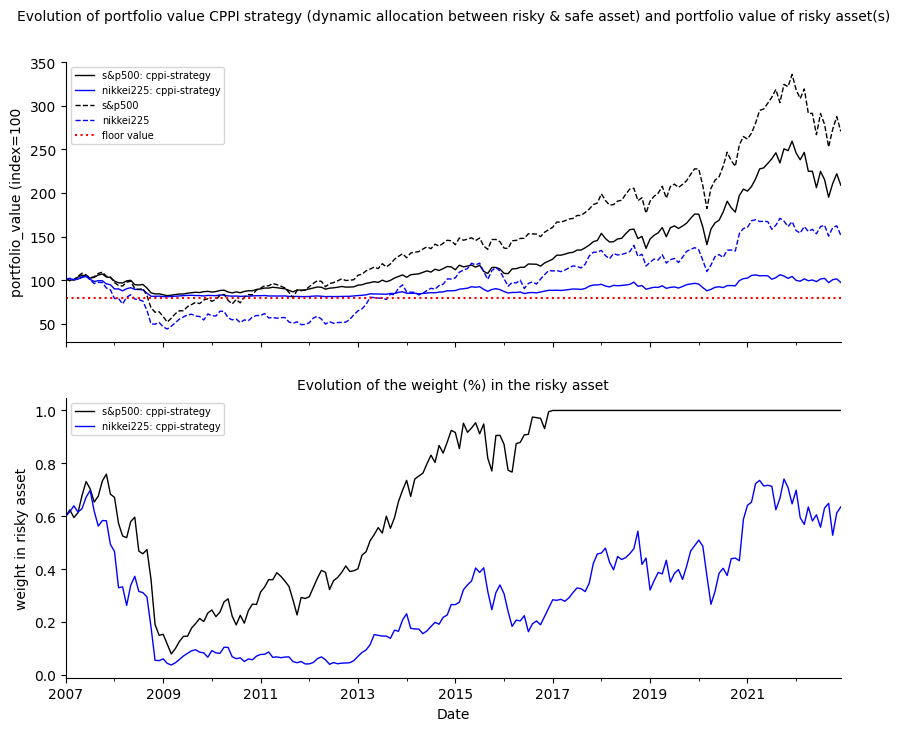

In [9]:
colors=['black','blue','darkorange','deepskyblue']

fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,8),sharex=True)

portfolio_value_history.plot(ax=ax1,linewidth=1,color=colors)
benchmark_history.plot(ax=ax1,color=colors,linestyle='--',linewidth=1)

ax1.axhline(y=floor_value,linestyle=':',color='red',label='floor value')
ax1.set_title('Evolution of portfolio value CPPI strategy (dynamic allocation between risky & safe asset) and portfolio value of risky asset(s)',fontsize=10,pad=30)
ax1.set_ylabel('portfolio_value (index=100')
ax1.legend(fontsize=7)


risky_weight_history.plot(ax=ax2,linewidth=1,color=colors)
ax2.set_title('Evolution of the weight (%) in the risky asset',fontsize=10)
ax2.set_ylabel('weight in risky asset')
ax2.legend(fontsize=7)


sns.despine()
plt.show()


## 5.  Built the CPPI algo in a function

In [62]:
def cppi(risky_returns,safe_returns=None,riskfree_rate=0.03,period=12,start=100,m=3,floor=0.8,drawdown=None,show_plot=True):
    """ Runs a Constant Proportion Portfolio Insurance strategy.
    
    Args:
        risky_returns(Series or DataFrame): The sequence of returns for the risky asset(s).
        safe_returns(None or Series): The sequence of returns for the safe asset (tbill or treasury). If None, a Series or DataFrame             is created and filled with the riskfree_rate dividend by the period.
        riskfree_rate(float): The annual riskfree_rate. This float is used when safe_returns is None and adjusted by period.
        period(int): The period is an adjustment factor to calculate with the annual riskfree_rate.
        start (float): Start value of the portfolio.
        m(float): The multiplicator used to multiply the cushion to find the weight in the risky asset(s).
        floor(float): The percentage floor that needs to be protected.
        
    Returns:
        dict: Dictionary with the history of portfolio values, risky weights, safe weights, floor values, cushions and benchmark(s).
    
    """
    
    risky_asset_returns=risky_returns
    if isinstance(risky_asset_returns,pd.Series):
        risky_asset_returns=pd.DataFrame(risky_asset_returns,columns=[risky_asset_returns.name])
    
    if safe_returns is None:
        safe_returns=pd.DataFrame().reindex_like(risky_asset_returns)
        safe_returns.values[:]=riskfree_rate/period
    safe_asset_returns=safe_returns
    
    dates=risky_asset_returns.index
    steps=len(dates)
    start_value=start
    portfolio_value=start_value
    peak_value=portfolio_value
    floor_value=floor*start_value
    
    portfolio_value_history=pd.DataFrame().reindex_like(risky_asset_returns)
    peak_value_history=pd.DataFrame().reindex_like(risky_asset_returns)
    risky_weight_history=pd.DataFrame().reindex_like(risky_asset_returns)
    safe_weight_history=pd.DataFrame().reindex_like(risky_asset_returns)
    floor_history=pd.DataFrame().reindex_like(risky_asset_returns)
    cushion_history=pd.DataFrame().reindex_like(risky_asset_returns)
    benchmark_history=pd.DataFrame().reindex_like(risky_asset_returns)
    
    if isinstance(risky_asset_returns.columns[0],str):
        portfolio_value_history.columns=[name+': cppi-strategy' for name in risky_asset_returns.columns]
        peak_value_history.columns=[name+': cppi-strategy' for name in risky_asset_returns.columns]
        risky_weight_history.columns=[name+': cppi-strategy' for name in risky_asset_returns.columns]
        safe_weight_history.columns=[name+': cppi-strategy' for name in risky_asset_returns.columns]
        floor_history.columns=[name+': floor' for name in risky_asset_returns.columns]
        cushion_history.columns=[name+': cppi-strategy' for name in risky_asset_returns.columns]
   
    
    for step in range(steps):
        
        if drawdown is not None:
            peak_value=np.maximum(portfolio_value,peak_value)
            floor_value=(1-drawdown)*peak_value
        cushion=(portfolio_value-floor_value)/portfolio_value
    
        risky_weight=m*cushion
        risky_weight=np.minimum(1,risky_weight)
        risky_weight=np.maximum(0,risky_weight)    
        safe_weight=1-risky_weight
    
        risky_value=risky_weight*portfolio_value
        safe_value=safe_weight*portfolio_value
        portfolio_value=risky_value*(1+risky_asset_returns.iloc[step]) + safe_value*(1+safe_asset_returns.iloc[step])  
   
    
        portfolio_value_history.iloc[step]=portfolio_value
        peak_value_history.iloc[step]=peak_value
        risky_weight_history.iloc[step]=risky_weight
        safe_weight_history.iloc[step]=safe_weight
        floor_history.iloc[step]=floor_value
        cushion_history.iloc[step]=cushion
        benchmark_history=start_value*(1+risky_asset_returns).cumprod()
        
    btr={
        'portfolio_value_history':portfolio_value_history,
        'portfolio_drawdown_history':drawdown_series(portfolio_value_history.pct_change().dropna()),
        'peak_value_history':peak_value_history,
        'risky_weight_history':risky_weight_history,
        'safe_weight_history':safe_weight_history,
        'floor_history':floor_history,
        'cushion_history':cushion_history,
        'benchmark_history':benchmark_history,
        'benchmark_drawdown_history':drawdown_series(benchmark_history.pct_change().dropna())
    }
    
    if show_plot is True:
    
        colors=['black','blue','darkorange','deepskyblue']

        fig,(ax0,ax1,ax2,ax3)=plt.subplots(4,1,figsize=(12,8),sharex=True)
    
        btr['portfolio_value_history'].plot(ax=ax0,linewidth=1,color=colors)
        btr['floor_history'].plot(ax=ax0,color=colors,linestyle=':',linewidth=1)
        ax0.set_title(f'Evolution CPPI strategy',fontsize=10,pad=30)
        ax0.set_ylabel('portfolio_value (index=100')
        ax0.legend(fontsize=7)
    

        btr['portfolio_value_history'].plot(ax=ax1,linewidth=1,color=colors)
        btr['benchmark_history'].plot(ax=ax1,color=colors,linestyle='--',linewidth=1)
        btr['floor_history'].plot(ax=ax1,color=colors,linestyle=':',linewidth=1)

        ax1.set_title(f'Evolution CPPI strategy and portfolio value of risky asset(s)',fontsize=10)
        ax1.set_ylabel('portfolio_value (index=100')
        ax1.legend(fontsize=7)


        btr['risky_weight_history'].plot(ax=ax2,linewidth=1,color=colors)
        ax2.set_title('Evolution of the weight (%) in the risky asset',fontsize=10)
        ax2.set_ylabel('weight in risky asset')
        ax2.legend(fontsize=7)

        btr['portfolio_drawdown_history'].plot(ax=ax3,linewidth=1,color=colors)
        btr['benchmark_drawdown_history'].plot(ax=ax3,linewidth=1,linestyle='--',color=colors)
        if drawdown is not None:
            ax3.axhline(y=-1*drawdown,linestyle='--',label='drawdown to protect',color='red')
        ax3.set_title('Rolling drawdowns',fontsize=10)
        ax3.set_ylabel('drawdown')
        ax3.legend(fontsize=7)
    
        sns.despine()
    
    
    return btr

In [23]:
type(risky_returns_df['s&p500'])

pandas.core.series.Series

## 6.  Run the CPPI algo through a function

TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

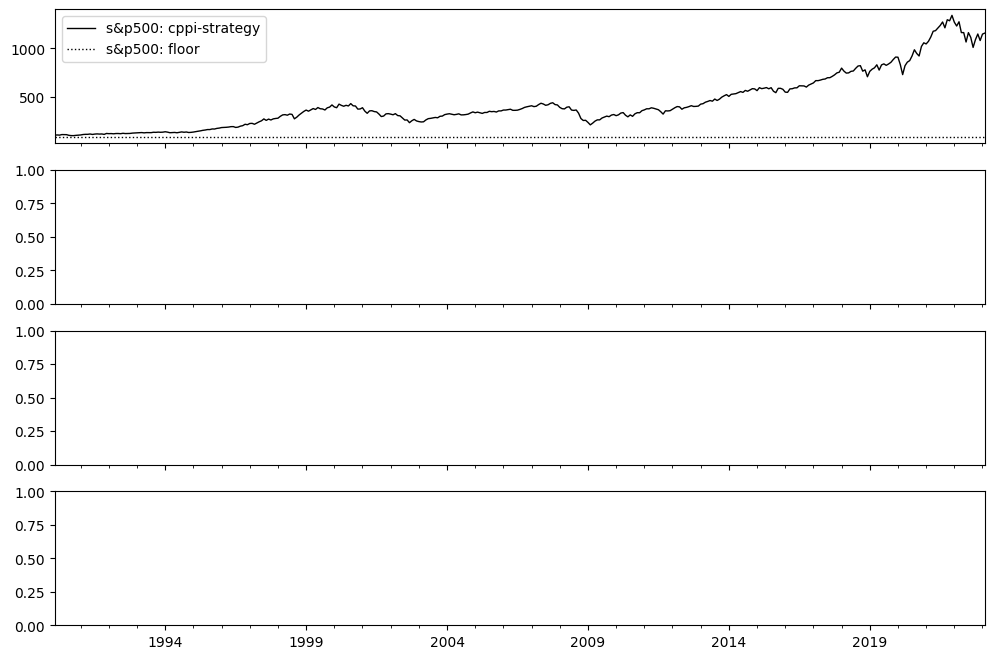

In [15]:
btr=cppi(risky_returns_df['s&p500'],tbill_monthly_return,period=12,start=100,m=3,
              drawdown=0.25,show_plot=True)

In [12]:
x=performance_metrics_absolute('cppi strategy',btr['portfolio_value_history'].pct_change().dropna().squeeze(),tbill_monthly_return,per=12)
y=performance_metrics_absolute('benchmark',btr['benchmark_history'].pct_change().dropna().squeeze(),tbill_monthly_return,per=12)
z=pd.concat([x,y],axis=1)
z

,cppi strategy,benchmark
absolute performance metrics,,
CAGR %,5.56,7.93
Volatility %,8.29,14.9
Downside volatility %,6.06,10.89
Max drawdown %,-22.98,-52.56
Sharpe ratio,0.36,0.36
Sortino ratio,0.5,0.49
MAR ratio,0.24,0.15
,,
Best month %,7.58,12.68


## 7.  Testing the CPPI with Monte Carlo and Block Bootstrapping